## Data Inspection & Data Cleaning

In [81]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from xgboost import XGBClassifier

In [15]:
# Load the dataset
df = pd.read_csv("rolling_stones_spotify.csv")
df.head(3)

,Unnamed: 0,name,album,release_date,track_number,id,uri,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms
0,0,Concert Intro Music - Live,Licked Live In NYC,2022-06-10,1,2IEkywLJ4ykbhi1yRQvmsT,spotify:track:2IEkywLJ4ykbhi1yRQvmsT,0.0824,0.463,0.993,0.996,0.932,-12.913,0.1100,118.001,0.0302,33,48640
1,1,Street Fighting Man - Live,Licked Live In NYC,2022-06-10,2,6GVgVJBKkGJoRfarYRvGTU,spotify:track:6GVgVJBKkGJoRfarYRvGTU,0.4370,0.326,0.965,0.233,0.961,-4.803,0.0759,131.455,0.3180,34,253173
2,2,Start Me Up - Live,Licked Live In NYC,2022-06-10,3,1Lu761pZ0dBTGpzxaQoZNW,spotify:track:1Lu761pZ0dBTGpzxaQoZNW,0.4160,0.386,0.969,0.400,0.956,-4.936,0.1150,130.066,0.3130,34,263160


In [16]:
# Convert release_date to song age
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['song_age'] = pd.Timestamp.now().year - df['release_date'].dt.year

In [17]:
# Drop irrelevant columns for exploratory data analysis 
drop_columns = ['id', 'uri','Unnamed: 0','release_date', 'track_number']
df = df.drop(columns=drop_columns, errors='ignore')

print("\nDataset after cleaning:")
print(df.info())


Dataset after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1610 entries, 0 to 1609
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1610 non-null   object 
 1   album             1610 non-null   object 
 2   acousticness      1610 non-null   float64
 3   danceability      1610 non-null   float64
 4   energy            1610 non-null   float64
 5   instrumentalness  1610 non-null   float64
 6   liveness          1610 non-null   float64
 7   loudness          1610 non-null   float64
 8   speechiness       1610 non-null   float64
 9   tempo             1610 non-null   float64
 10  valence           1610 non-null   float64
 11  popularity        1610 non-null   int64  
 12  duration_ms       1610 non-null   int64  
 13  song_age          1610 non-null   int64  
dtypes: float64(9), int64(3), object(2)
memory usage: 176.2+ KB
None


In [18]:
# Check for missing values
df_missing = df.isnull().sum()
df_missing

name                0
album               0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
popularity          0
duration_ms         0
song_age            0
dtype: int64

In [19]:
# Check for duplicates based on name + album
df = df.drop_duplicates(subset=['name', 'album'], keep='first')

In [20]:
df.describe()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms,song_age
count,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.00000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000
mean,0.246145,0.466187,0.794584,0.168866,0.494788,-6.90233,0.068716,126.220030,0.581718,20.836207,257084.870027,33.020557
std,0.226760,0.142239,0.179656,0.279882,0.349929,2.96934,0.049422,29.325185,0.233453,12.287329,106942.195517,22.418182
min,0.000009,0.104000,0.141000,0.000000,0.021900,-24.40800,0.023200,46.525000,0.000000,0.000000,21000.000000,3.000000
25%,0.054475,0.360000,0.677000,0.000255,0.153000,-8.93150,0.036500,107.467000,0.402750,14.000000,190626.000000,8.000000
50%,0.176000,0.454000,0.852000,0.014050,0.385000,-6.42500,0.050900,124.477500,0.582500,20.000000,242839.500000,36.000000
75%,0.400000,0.572000,0.946000,0.186000,0.895750,-4.58250,0.085425,142.464000,0.781000,27.000000,295589.750000,55.000000
max,0.994000,0.887000,0.999000,0.996000,0.998000,-1.01400,0.624000,216.304000,0.974000,80.000000,981866.000000,61.000000


In [22]:
# Identify and remove extreme outliers using IQR
from helper import removeOutliers
numeric_columns = df.select_dtypes(include=['number']).columns
df = removeOutliers(df, numeric_columns, iqr=True)
df.describe()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms,song_age
count,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000
mean,0.232804,0.477347,0.782061,0.049000,0.475141,-6.905568,0.059358,123.137844,0.591386,19.849904,247861.424474,32.804015
std,0.214507,0.137891,0.177764,0.092060,0.345007,2.730732,0.030505,27.246667,0.223820,10.659741,75081.416113,22.296669
min,0.000009,0.104000,0.274000,0.000000,0.021900,-14.730000,0.023200,57.772000,0.024900,0.000000,35920.000000,3.000000
25%,0.053025,0.377000,0.658500,0.000083,0.150250,-9.022250,0.036300,105.417000,0.422250,13.000000,191619.750000,8.000000
50%,0.166500,0.463500,0.830500,0.004730,0.353000,-6.530500,0.048000,121.489500,0.591000,20.000000,244659.500000,36.000000
75%,0.381750,0.584750,0.940000,0.048950,0.872000,-4.673250,0.074100,139.961000,0.783000,26.750000,293786.500000,55.000000
max,0.900000,0.887000,0.997000,0.462000,0.998000,-1.382000,0.158000,193.588000,0.974000,46.000000,451960.000000,61.000000


## Exploratory Data Analysis

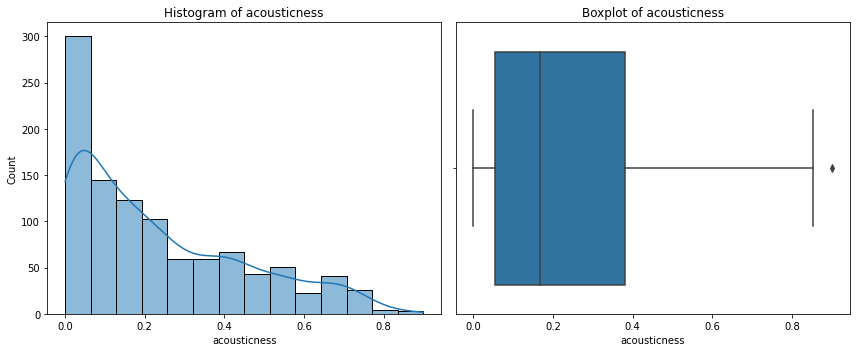

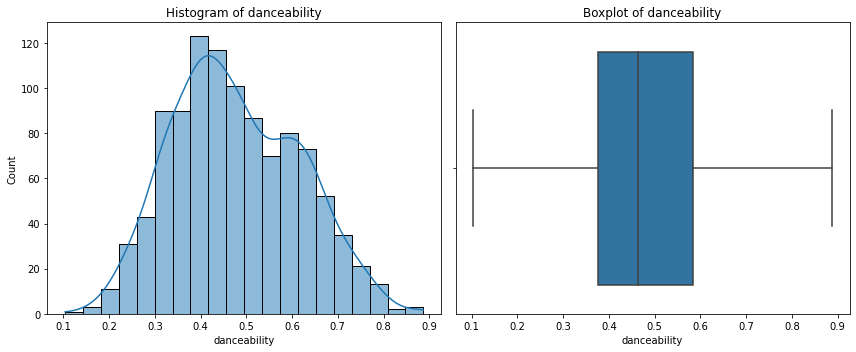

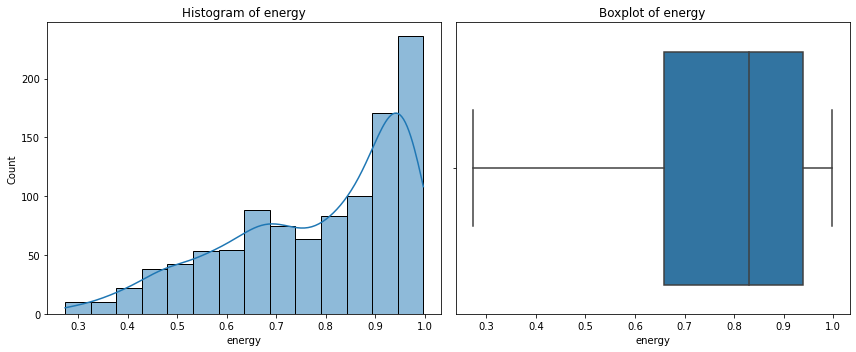

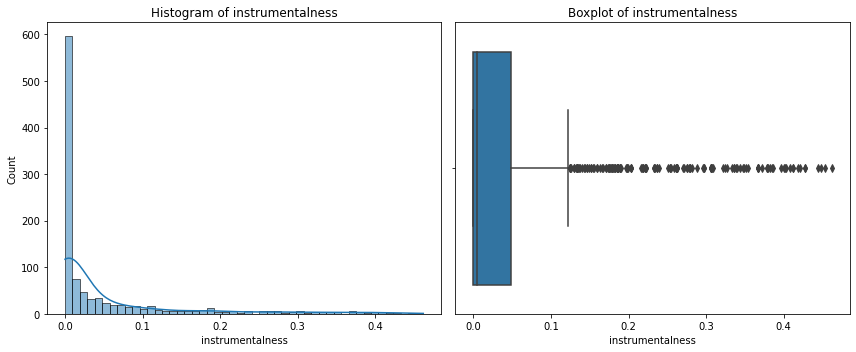

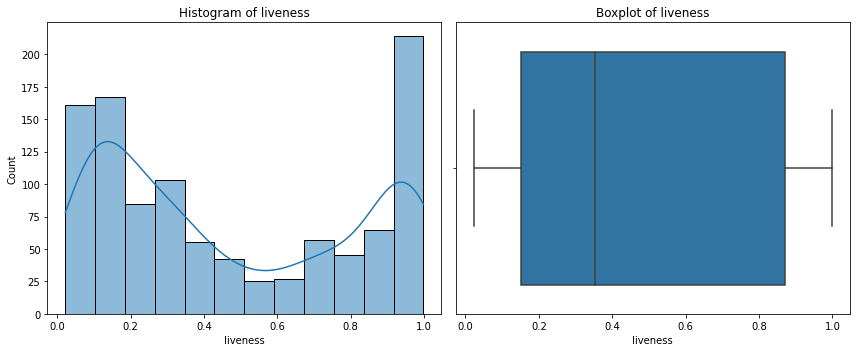

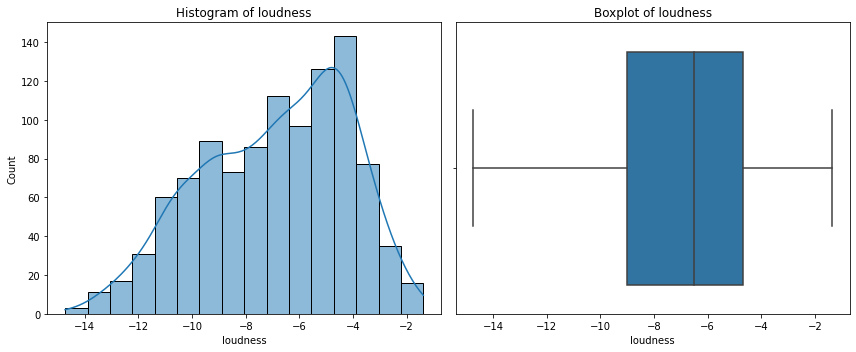

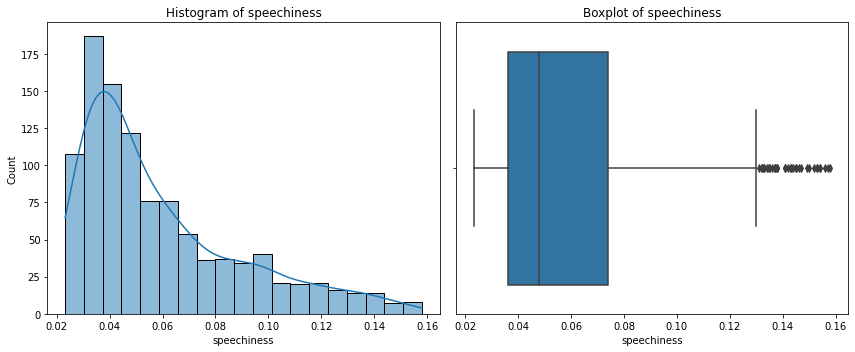

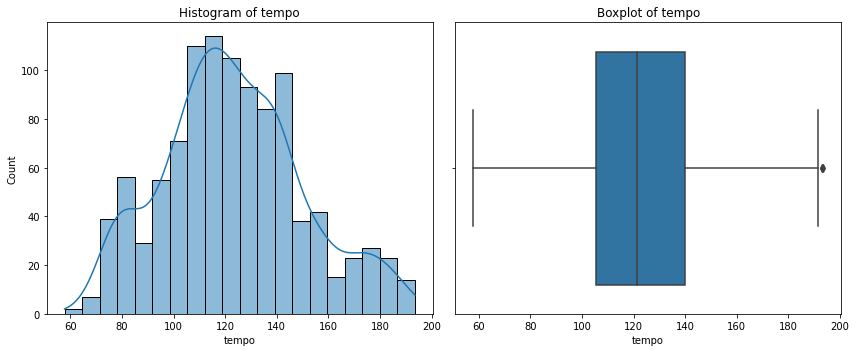

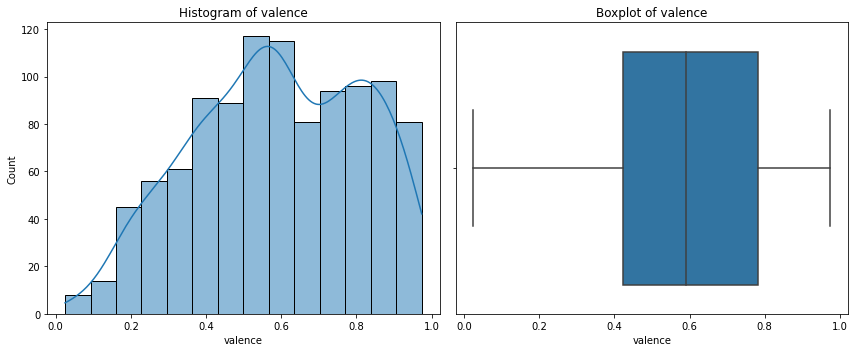

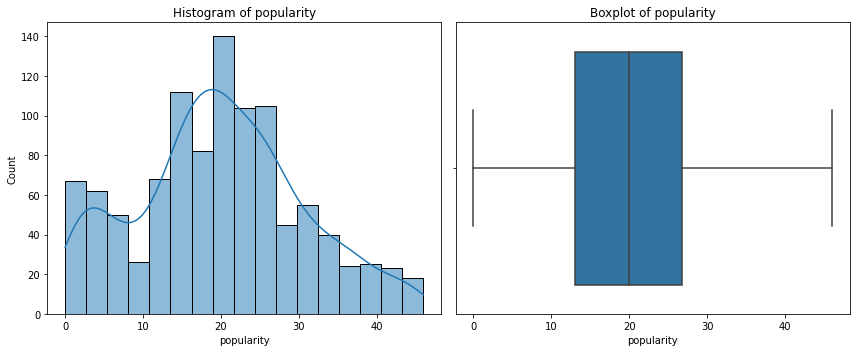

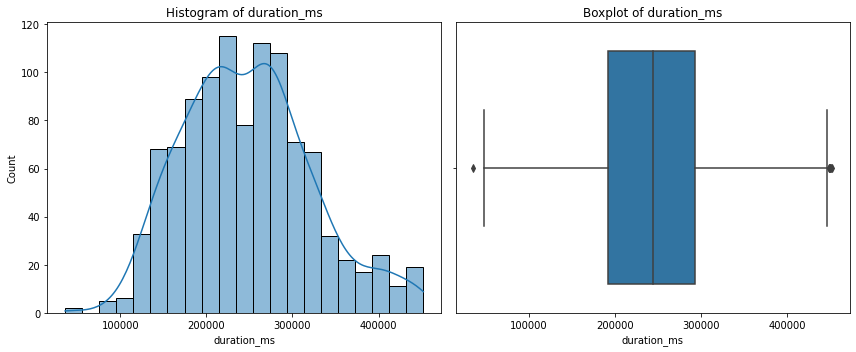

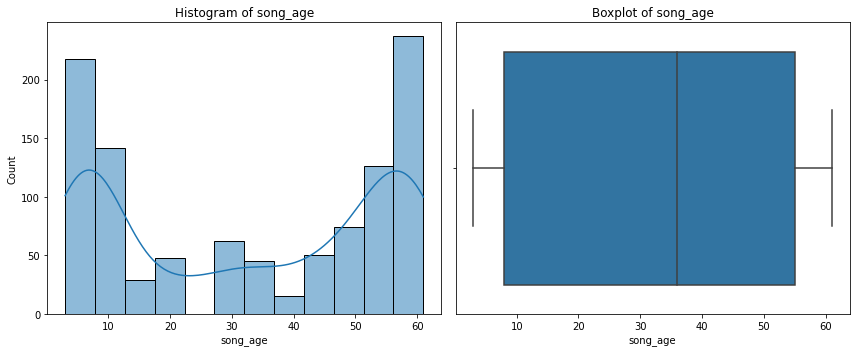

In [23]:
# Visualizing distributions and outliers for continuous features
cont_features = df.select_dtypes(include=['number']).columns.tolist()

for feature in cont_features:
    plt.figure(figsize=(12, 5))  # Adjust figure size
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=feature, kde=True)
    plt.title(f"Histogram of {feature}")
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, x=feature)
    plt.title(f"Boxplot of {feature}")
    
    plt.tight_layout()  # Prevent overlapping
    plt.show()

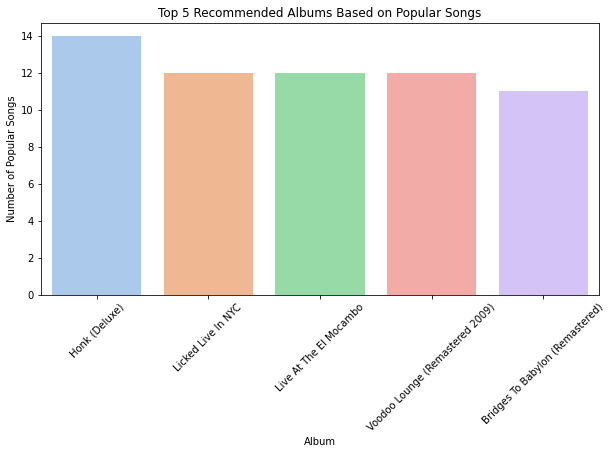

In [30]:
# Identify top albums based on popular songs
popularity_threshold = df['popularity'].quantile(0.75)  # Top 25% most popular songs
top_albums = df[df['popularity'] >= popularity_threshold].groupby('album').size().sort_values(ascending=False)

# Select top 5 albums
top_5_albums = top_albums.head(5)

# Visualize the top albums
plt.figure(figsize=(10, 5))
sns.barplot(x=top_5_albums.index, y=top_5_albums.values, palette='pastel')
plt.title("Top 5 Recommended Albums Based on Popular Songs")
plt.xlabel("Album")
plt.ylabel("Number of Popular Songs")
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_67/2541931477.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.5)


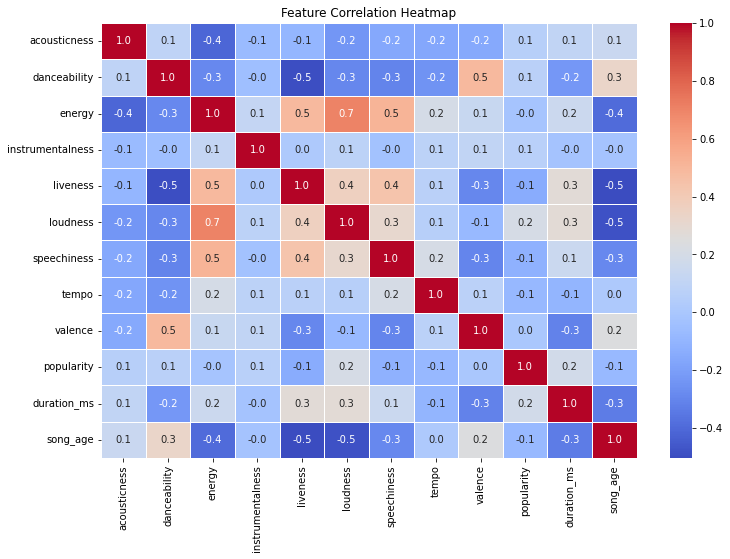

In [33]:
# Feature Correlation Analysis
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

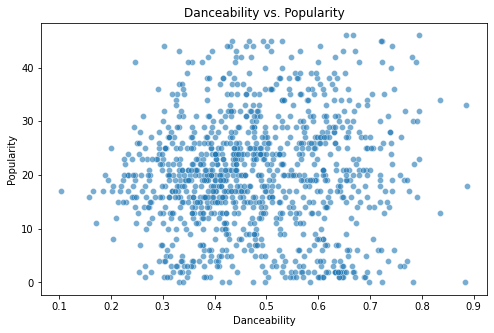

In [34]:
# Check if Danceability Affect Popularity
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='danceability', y='popularity', alpha=0.6)
plt.title("Danceability vs. Popularity")
plt.xlabel("Danceability")
plt.ylabel("Popularity")
plt.show()

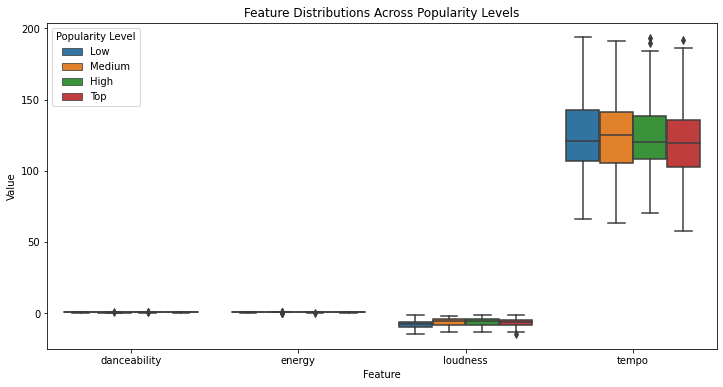

In [36]:
# Distribution of Features Across Popularity Levels
df['popularity_level'] = pd.qcut(df['popularity'], q=4, labels=["Low", "Medium", "High", "Top"])

# Compare feature distributions
features_to_plot = ['danceability', 'energy', 'loudness', 'tempo']
df_melted = df.melt(id_vars=['popularity_level'], value_vars=features_to_plot)

plt.figure(figsize=(12, 6))
sns.boxplot(x='variable', y='value', hue='popularity_level', data=df_melted)
plt.title("Feature Distributions Across Popularity Levels")
plt.xlabel("Feature")
plt.ylabel("Value")
plt.legend(title="Popularity Level")
plt.show()


In [43]:
# Regression Analysis (Predicting Popularity)

# Select relevant features
features = df.select_dtypes(include=['number']).columns.drop('popularity')
X = df[features]
y = df['popularity']

# Train a regression model
model = LinearRegression()
model.fit(X, y)

# Print feature importance
coefficients = pd.Series(model.coef_, index=features)
print("\nFeature Importance in Predicting Popularity_Linear Regression")
print(coefficients.sort_values(ascending=False))


Feature Importance in Predicting Popularity_Linear Regression
instrumentalness     6.862636
danceability         4.496968
acousticness         1.888185
loudness             1.395922
valence              0.118031
duration_ms          0.000023
tempo               -0.003712
song_age            -0.027854
liveness            -6.425507
energy              -9.067975
speechiness        -25.007546
dtype: float64


## Apply Dimensionality Reduction - Principal Component Analysis (PCA)

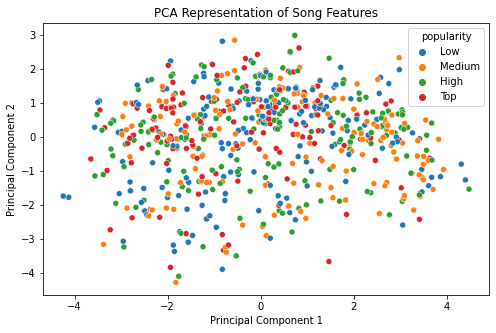

In [45]:
from sklearn.decomposition import PCA

# Selecting the most relevant features before PCA
selected_features = coefficients[coefficients.abs() > 1].index.tolist()
X_selected = df[selected_features]

# Apply PCA for dimensionality reduction
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)  # Reduce to 2 principal components
X_pca = pca.fit_transform(X_scaled)

# Convert PCA result to DataFrame
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['popularity'] = df['popularity']

# Visualizing PCA
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue=pd.qcut(df_pca['popularity'], q=4, labels=["Low", "Medium", "High", "Top"]))
plt.title("PCA Representation of Song Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


In [ ]:
## Insight: PCA shows that popularity is not strongly correlated with the top two principal components

## Unsupervised Machine Learning for Clustering Analysis

In [76]:
# Selecting features for clustering
features = ['instrumentalness', 'danceability', 'liveness', 'energy', 'speechiness']
X = df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

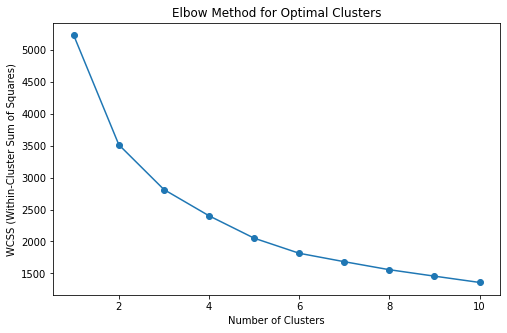

In [77]:
# Identify the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

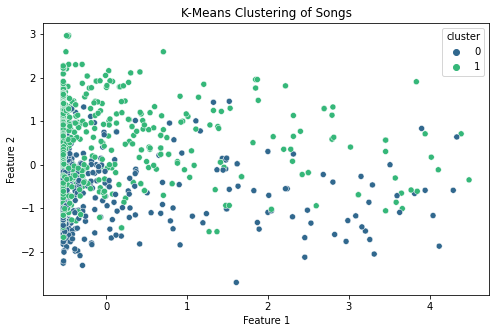

In [78]:
# Apply K-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=df['cluster'], palette='viridis')
plt.title("K-Means Clustering of Songs")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [79]:
# Analyze cluster characteristics
cluster_means = df.groupby('cluster')[features].mean()
print("\nCluster Characteristics:")
print(cluster_means)


Cluster Characteristics:
         instrumentalness  danceability  liveness    energy  speechiness
cluster                                                                 
0                0.049170      0.390186  0.801897  0.904841     0.079156
1                0.048872      0.542391  0.231301  0.690437     0.044584


In [80]:
# Apply Silhouette Score
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X_scaled, df['cluster'])
print(f"\nSilhouette Score: {sil_score:.3f}")


Silhouette Score: 0.310


## Supervised ML Using XGBoost

In [85]:
# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df['cluster'], test_size=0.2, random_state=42, stratify=df['cluster'])

# Train XGBoost on cluster labels
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on both train and test sets
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

In [86]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on training set
print("\nXGBoost Clustering Model Evaluation (Train Set):")
print(classification_report(y_train, y_train_pred))
print("Confusion Matrix (Train Set):")
print(confusion_matrix(y_train, y_train_pred))

# Evaluate the model on test set
print("\nXGBoost Clustering Model Evaluation (Test Set):")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_test_pred))


XGBoost Clustering Model Evaluation (Train Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       357
           1       1.00      1.00      1.00       479

    accuracy                           1.00       836
   macro avg       1.00      1.00      1.00       836
weighted avg       1.00      1.00      1.00       836

Confusion Matrix (Train Set):
[[357   0]
 [  0 479]]

XGBoost Clustering Model Evaluation (Test Set):
              precision    recall  f1-score   support

           0       0.99      0.94      0.97        90
           1       0.96      0.99      0.98       120

    accuracy                           0.97       210
   macro avg       0.97      0.97      0.97       210
weighted avg       0.97      0.97      0.97       210

Confusion Matrix (Test Set):
[[ 85   5]
 [  1 119]]
